In [ ]:
# best 3 sophisticated methods to solve this time series problem are LSTM, GNN, ARCH

In [5]:
import numpy as np
import pandas as pd

train_1=pd.read_csv(r"D:\Rohan\ML\Datasets\web-traffic-time-series-forecasting\train_1.csv")

In [2]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [7]:
#extracting a stationary time series and a non-stationary time series
stationary_page_name=train_1["Page"][0]
stationary_page_row=train_1[train_1["Page"]==stationary_page_name]
stationary_time_series=stationary_page_row.drop(columns=["Page"])
stationary_time_series=stationary_time_series.values.flatten()

In [8]:
#EDA
#detecting outliers using zscore method and removing them
mean = np.mean(stationary_time_series)
std_dev = np.std(stationary_time_series)
z_scores = [(y - mean) / std_dev for y in stationary_time_series]
outliers = np.where(np.abs(z_scores) > 3)

print(outliers)

(array([101, 279, 280, 283, 353, 374, 513], dtype=int64),)


In [9]:
stationary_time_series = np.delete(stationary_time_series, outliers)

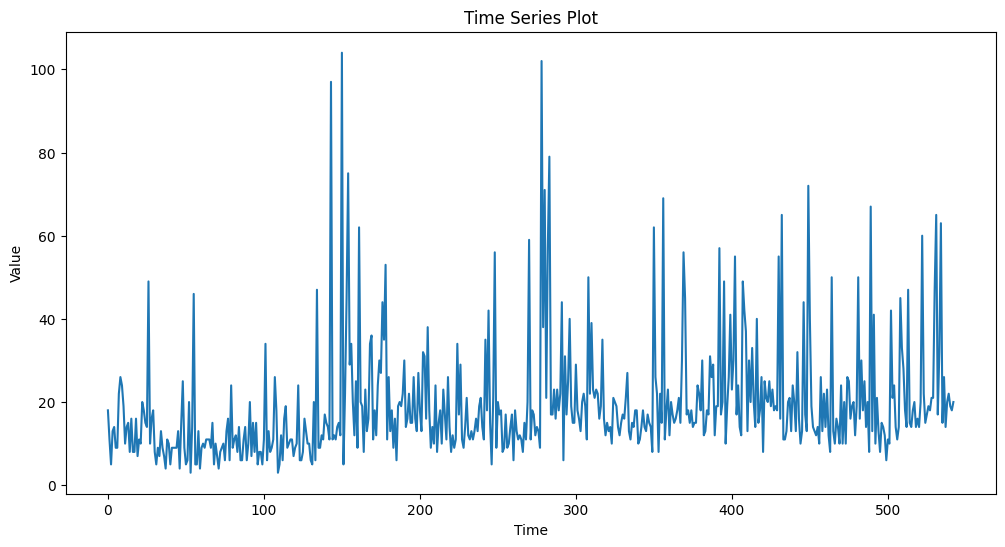

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(stationary_time_series)
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [11]:
# checking whether data of 1 page is stationary or not
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.stattools import kpss


# Perform ADF test
adf_test = ADF(stationary_time_series)
adf_stat = adf_test.stat
adf_pvalue = adf_test.pvalue
adf_critical_values = adf_test.critical_values


# Perform Phillips-Perron test
pp_test = PhillipsPerron(stationary_time_series)
pp_stat = pp_test.stat
pp_pvalue = pp_test.pvalue
pp_critical_values = pp_test.critical_values

# KPSS test
kpss_stat, kpss_pvalue, kpss_lags, kpss_critical_values= kpss(stationary_time_series, regression='c')



adf_result = adf_pvalue < 0.05
pp_result = pp_pvalue < 0.05
kpss_result = kpss_pvalue > 0.05


# Store results in a DataFrame
stationarity_results = pd.DataFrame({
    'Test': ['ADF', 'Phillips-Perron', 'KPSS'],
    'Statistic': [adf_stat, pp_stat, kpss_stat],
    'p-value': [adf_pvalue, pp_pvalue, kpss_pvalue],
    '1% Critical Value': [adf_critical_values.get('1%'), pp_critical_values.get('1%'), kpss_critical_values.get('1%')],
    '5% Critical Value': [adf_critical_values.get('5%'), pp_critical_values.get('5%'), kpss_critical_values.get('5%')],
    '10% Critical Value': [adf_critical_values.get('10%'), pp_critical_values.get('10%'), kpss_critical_values.get('10%')],
    'Stationarity': [adf_result, pp_result, kpss_result]
})

stationarity_results.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2244\4158992202.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, kpss_lags, kpss_critical_values= kpss(stationary_time_series, regression='c')


,Test,Statistic,p-value,1% Critical Value,5% Critical Value,10% Critical Value,Stationarity
0,ADF,-8.413415,2.074325e-13,-3.442541,-2.866917,-2.569634,True
1,Phillips-Perron,-24.108902,0.000000e+00,-3.442473,-2.866887,-2.569618,True
2,KPSS,1.398984,1.000000e-02,0.739000,0.463000,0.347000,False


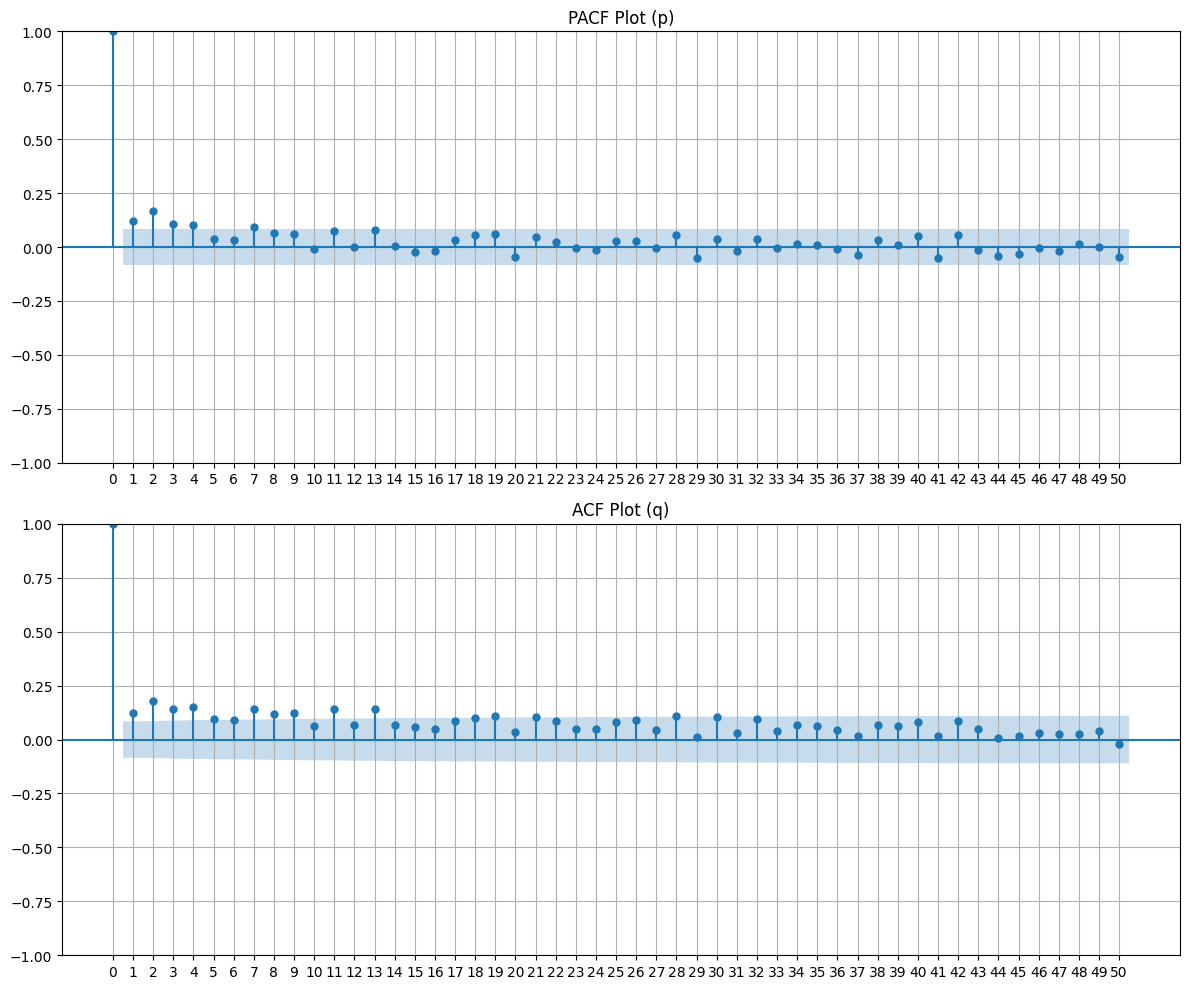

In [12]:
"""
p - PACF plot, point where plot cuts off
d - 0, since data is already stationary, no need to do differencing
q - ACF plot, point where plot cuts off

the cutoff value in a PACF plot is the value on x-axis where the values start getting in the highlighted range (confidence interval band)

If your time series has 550 observations, specifying lags=50 means that the partial autocorrelation will be calculated for the
first lag up to the 50th lag, taking into account all 550 data points for each lag's calculation.

"""

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

plot_pacf(stationary_time_series, lags=50, ax=ax[0])
ax[0].set_title('PACF Plot (p)')
ax[0].set_xticks(np.arange(0, 51, 1))
ax[0].grid(True)

plot_acf(stationary_time_series, lags=50, ax=ax[1])
ax[1].set_title('ACF Plot (q)')
ax[1].set_xticks(np.arange(0, 51, 1))
ax[1].grid(True)

plt.tight_layout()
plt.show()

# (p,d,q) is (4,0,23)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming time_series is your time series list
time_series = np.array(stationary_time_series)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(time_series_scaled, SEQ_LENGTH)

# Reshape X to fit LSTM input requirements
X = X.reshape((X.shape[0], X.shape[1], 1))


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=750, batch_size=32)


Epoch 1/750


d:\Rohan\Freelancing\posterior_predictive\posterior_predictive\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0236
Epoch 2/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0226
Epoch 3/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0220
Epoch 4/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0173
Epoch 5/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0184
Epoch 6/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0195
Epoch 7/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0199
Epoch 8/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0176
Epoch 9/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0192
Epoch 10/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0225
Epoch 11/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0228
Epoch 12/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0203
Epoch 13/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0199
Epoch 14/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0205
Epoch 15/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0191
E

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 2.725179657333601
MAE: 1.9140387485767234
MAPE: 14.659852064051012


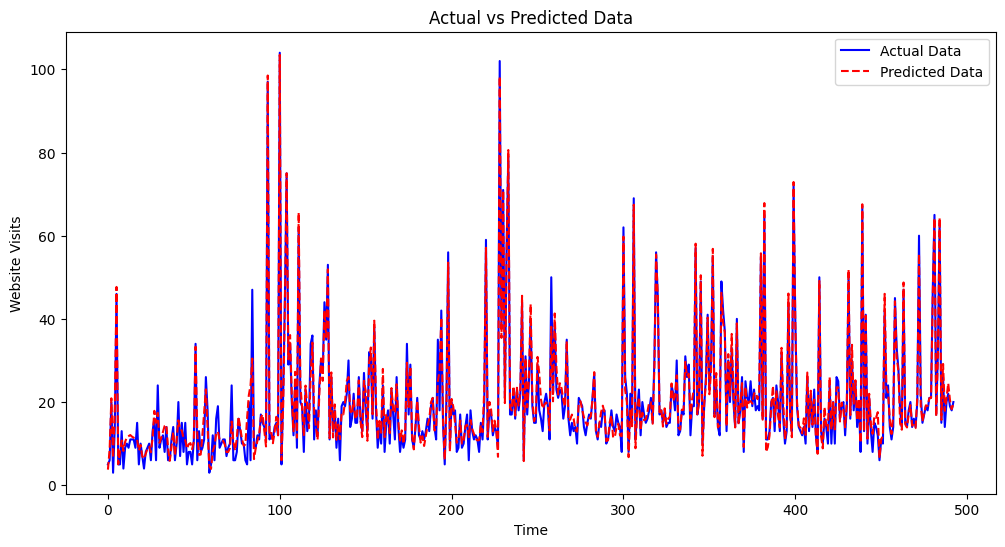

In [35]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform predictions and true values
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red', linestyle='--')
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Website Visits')
plt.legend()
plt.show()


In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming `stationary_time_series` is your time series list

# Parameters
seq_length = 30  # Sequence length used for training
n_predictions = 90  # Number of days to predict
n_simulations = 100  # Number of simulations to capture uncertainty

# Convert the list to a numpy array
stationary_time_series = np.array(stationary_time_series).reshape(-1, 1)

# Prepare the data
scaler = MinMaxScaler()
stationary_time_series_scaled = scaler.fit_transform(stationary_time_series)

# Get the last sequence to start predicting
last_sequence = stationary_time_series_scaled[-seq_length:]

# Function to predict the next `n_days` with uncertainty
def predict_with_uncertainty(model, last_sequence, n_days, n_simulations):
    predictions = []
    for _ in range(n_simulations):
        temp_sequence = last_sequence.copy().reshape(1, -1, 1)
        simulation_predictions = []
        for _ in range(n_days):
            pred = model.predict(temp_sequence)
            pred = pred.reshape(1, 1) 
            simulation_predictions.append(pred[0][0])
            temp_sequence = np.append(temp_sequence[:, 1:, :], [[pred]], axis=1)
        predictions.append(simulation_predictions)
    return np.array(predictions)

# Generate predictions
predictions = predict_with_uncertainty(model, last_sequence, n_predictions, n_simulations)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

# Calculate mean and confidence intervals
mean_predictions = np.mean(predictions, axis=0)
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(stationary_time_series)), scaler.inverse_transform(stationary_time_series), label='Historical Data')
plt.plot(range(len(stationary_time_series), len(stationary_time_series) + n_predictions), mean_predictions, label='Mean Prediction')
plt.fill_between(range(len(stationary_time_series), len(stationary_time_series) + n_predictions), lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Website Visits')
plt.title('90-Day Prediction with Posterior Predictive Distribution')
plt.legend()
plt.show()

# Print evaluation metrics (optional)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `true_values` is the true future values (if available)
# Uncomment and use this if you have true future values for evaluation
# mae = mean_absolute_error(true_values, mean_predictions)
# rmse = np.sqrt(mean_squared_error(true_values, mean_predictions))
# mape = np.mean(np.abs((true_values - mean_predictions) / true_values)) * 100

# print(f'MAE: {mae}')
# print(f'RMSE: {rmse}')
# print(f'MAPE: {mape}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 5 dimension(s)

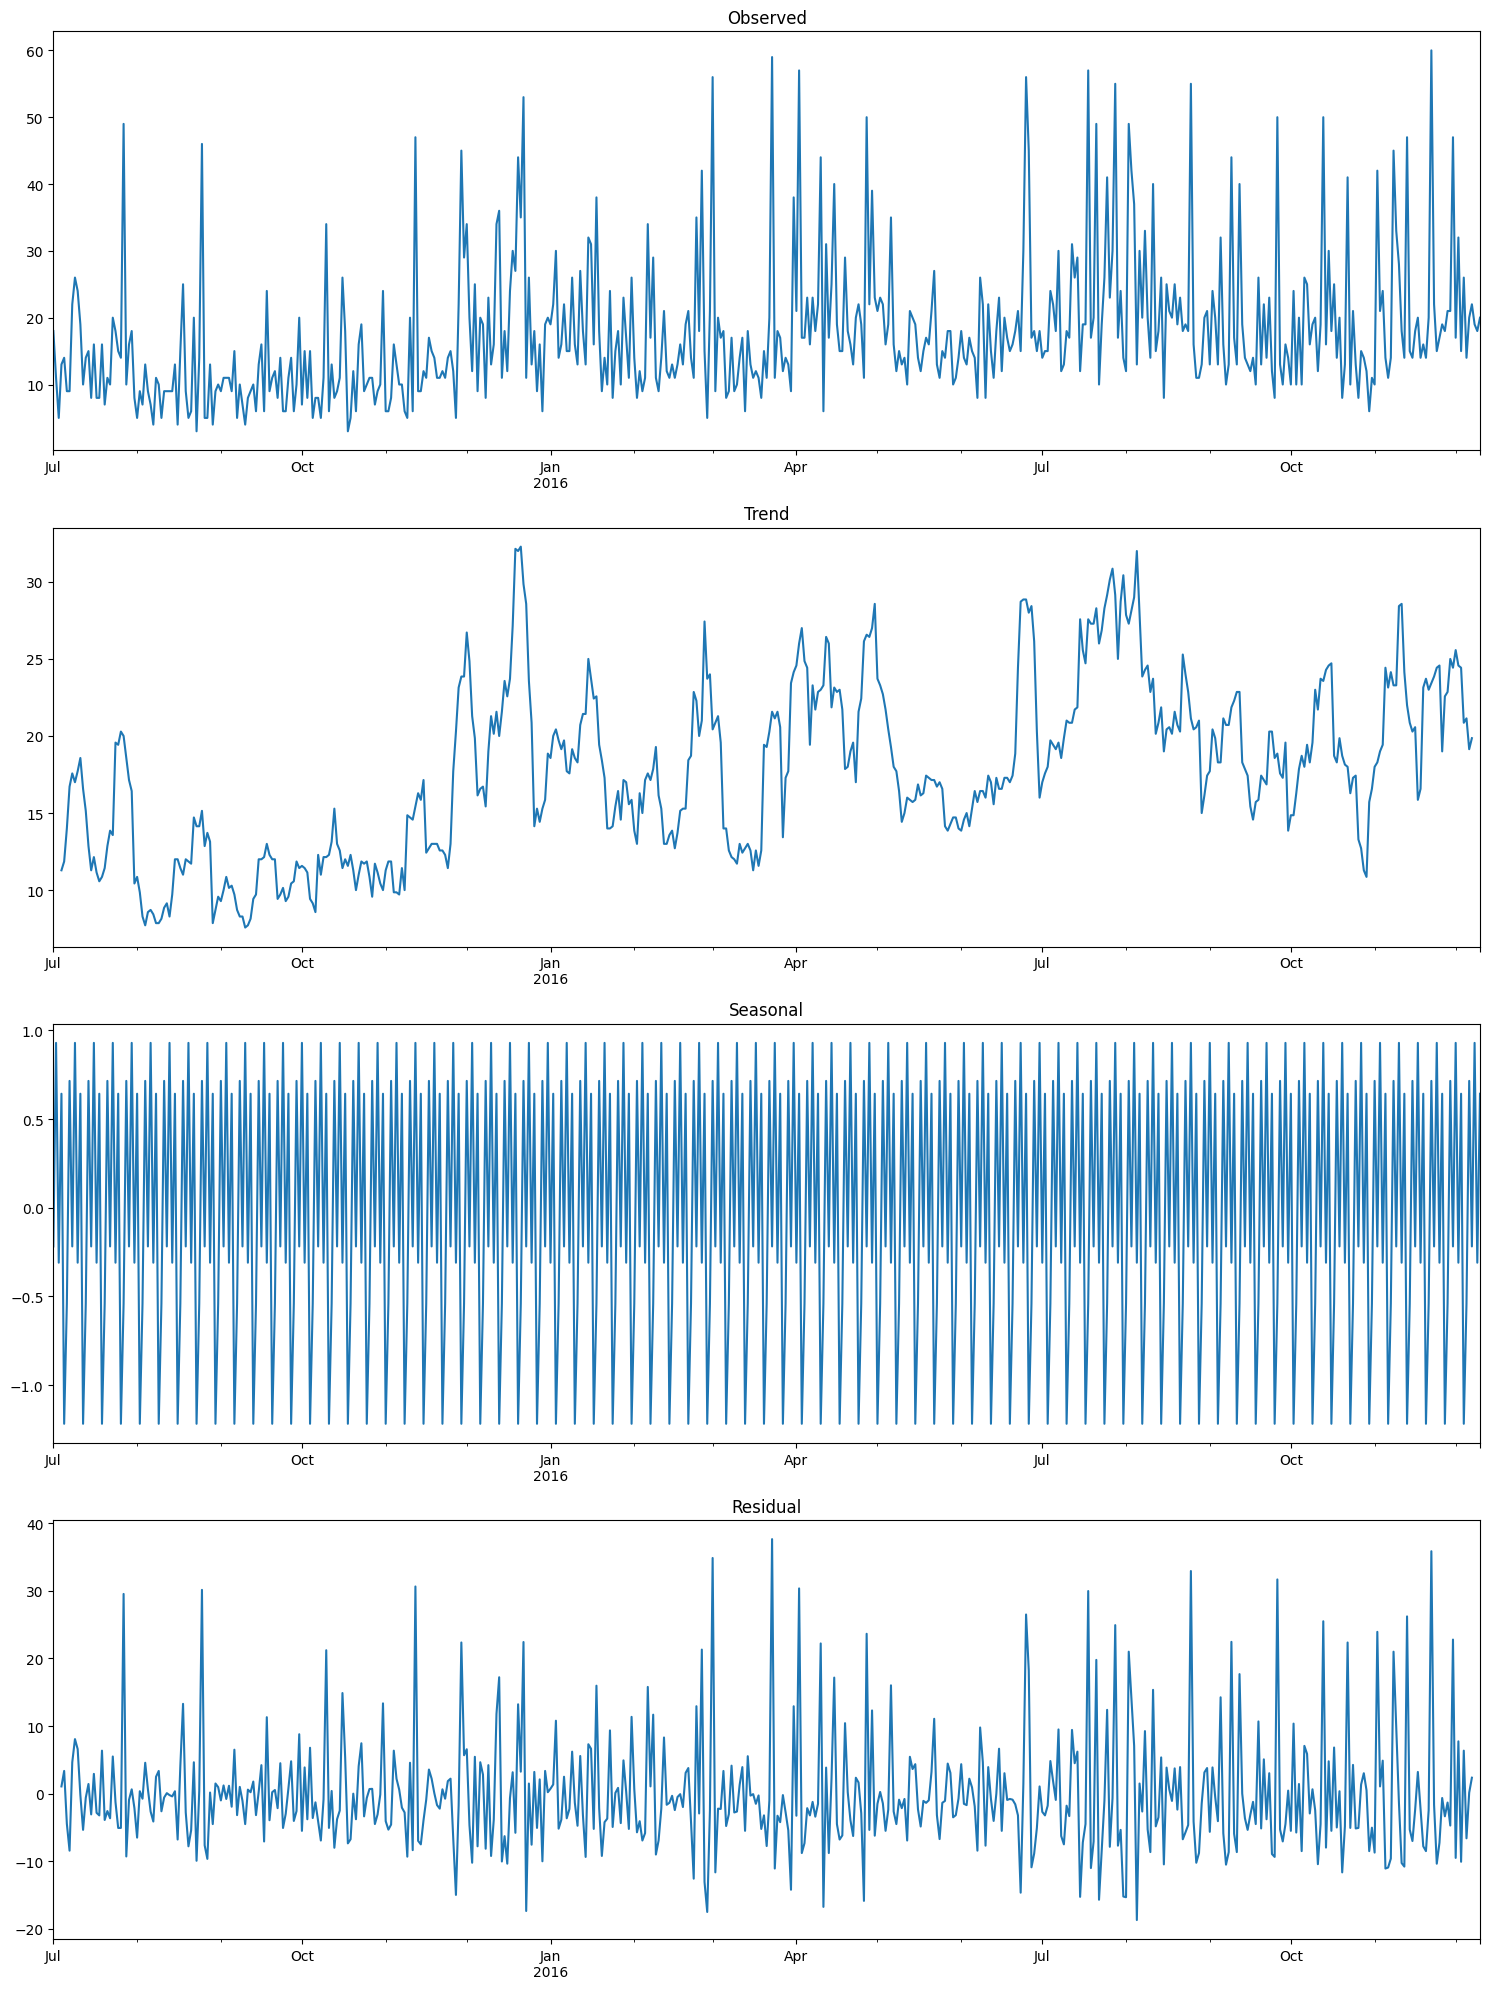

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example data
dates = pd.date_range(start='2015-07-01', periods=529, freq='D')
data = pd.Series(stationary_time_series, index=dates)

data.index.freq = 'D'

decomposition = seasonal_decompose(data, model='additive')

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()


In [ ]:
# add a pipeline to this code which preprocess data automatically